In [10]:
#@title Plotting Settings
def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max1=1.25, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, ylim_max1])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ()")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2]) 
  ax[1].set_ylabel("Membrane Potential ()")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([]) 

  plt.show()

def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.03, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.05, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_ylim([0, 10])

  plt.show()

def dvs_animator(spike_data):
  fig, ax = plt.subplots()
  anim = splt.animator((spike_data[:,0] + spike_data[:,1]), fig, ax)
  return anim


In [2]:
import snntorch as snn
from snntorch import spikeplot as splt
import torch

import matplotlib.pyplot as plt
from IPython.display import HTML

/home/laibakhan/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


# 1. The Leaky Integrate-and-Fire Neuron
   
   
          X -----------> 0 -----------> spike{0,1}
                        LIF
       (input)        (neuron)

if membrane potential reaches some thershold, it gets excited then it's going to trigger some output spike activity and then spike goint to be zero or 1


we want to excite neuron in some way: There are multiple ways 
1) input spike
2) step current
3) constant current

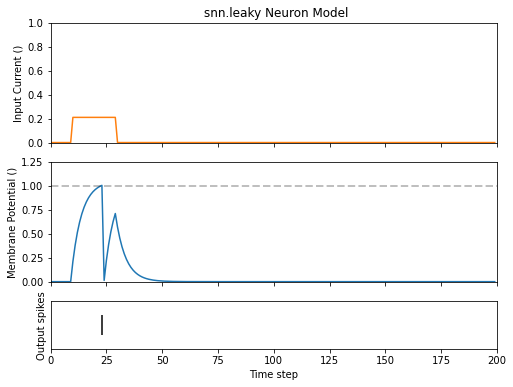

In [14]:
lif = snn.Leaky(beta=0.8) #decay rate of neuron membrane potential (an inverse time constant)

num_steps = 200 #to simulate
x = torch.cat((torch.zeros(10), torch.ones(20)*0.21, torch.zeros(170))) #step current
mem = torch.zeros(1)
spk = torch.zeros(1)


# Neuron SIMULATION
mem_rec = []
spk_rec = []

for step in range (num_steps):
    spk, mem = lif(x[step], mem)
    mem_rec.append(mem)
    spk_rec.append(spk)
    
# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)    
   
plot_cur_mem_spk(x, mem_rec, spk_rec, thr_line=1, ylim_max1 = 1.0,title = " snn.leaky Neuron Model")    

# Train an SNN Classifier

In [23]:
import torch.nn as nn #pytorch layers
from torch.utils.data import DataLoader #mnist data set
from torchvision import datasets, transforms
import numpy as np 
import itertools # to iterate over sample of data

#### DataLoading the mnist data set

In [28]:
batch_size = 128 # data set divided into bite sized pieces means 128 samples
data_path = './data'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [29]:
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)
     

100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100.0%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100.0%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [31]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

### Fully Connected SNN

In [33]:
from snntorch import surrogate

# network architecture 

num_inputs = 784 # 28*28
num_hidden = 1000
num_outputs = 10

num_steps = 25
beta = 0.95 # at every time step we are going to see 5% decrease of membrane potential from the previous mem


# define network
class Net(nn.module):
    def __init__(self):
        super().__init__()
        
        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)
        
    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        #record the final layer 
        spk2_rec = []
        mem2_rec = []
        
        #time loop
        for step in range(num_steps):
            cur1 = self.fc1(x.flatten(1)) #batch128 x 28*28 
            spk1, mem1 = self.lif1(cur1, mem1) # membrane exceeds the threshold spike one and will be zero if membrane does't exceed
            cur2 = self.fc2(spk1) #batch128 x 28*28 
            spk2, mem2 = self.lif2(cur2, mem2) 
            
            #store in list
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
            
        return torch.slack(spk2_rec, dim=0), torch.stack(mem2_rec,dim=0) #time step x batch x num_out
        

AttributeError: module 'torch.nn' has no attribute 'module'